In [29]:
# Imports
import menpo.io as mio
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import seaborn as sns

from menpo.visualize import print_progress
from menpo.landmark import labeller, face_ibug_68_to_face_ibug_68_trimesh, face_ibug_68_to_face_ibug_66_trimesh
from menpofit.aam import PatchAAM
from menpo.feature import fast_dsift
from menpofit.aam import LucasKanadeAAMFitter, WibergInverseCompositional
from menpodetect import load_dlib_frontal_face_detector
from menpofit.builder import warp_images
from menpofit.builder import build_reference_frame
from menpo.transform import PiecewiseAffine
from menpo.model import PCAModel
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn.metrics import confusion_matrix

from os.path import join

%matplotlib inline

/Users/206479300/anaconda2/envs/conda_env/lib/python2.7/site-packages/scipy/cluster/vq.py:88: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _vq
/Users/206479300/anaconda2/envs/conda_env/lib/python2.7/site-packages/scipy/cluster/hierarchy.py:178: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _hierarchy


### Train AAM model (Using subset of images)

In [3]:
# Replace these paths with your own paths before running the code
path_to_images = '/Users/206479300/Downloads/w210_dataset/Images/042-ll042/ll042t1aaaff/'
path_to_labels = '/Users/206479300/Downloads/w210_dataset/Frame_Labels/PSPI/042-ll042/ll042t1aaaff/'
training_images = []
training_labels = []

for pspi_file in os.listdir(path_to_labels):
    with open(join(path_to_labels, pspi_file), 'r') as f_in:
        training_labels.append(float(f_in.read().strip()))

for img in print_progress(mio.import_images(path_to_images, verbose=True)):
    # convert to greyscale
    if img.n_channels == 3:
        img = img.as_greyscale()
    # crop to landmarks bounding box with an extra 20% padding
    img = img.crop_to_landmarks_proportion(0.2)
    # rescale image if its diagonal is bigger than 400 pixels
    d = img.diagonal()
    if d > 400:
        img = img.rescale(400.0 / d)
    # define a TriMesh which will be useful for Piecewise Affine Warp of HolisticAAM
    #labeller(img, 'PTS', face_ibug_68_to_face_ibug_66_trimesh)
    # append to list
    training_images.append(img)

Found 683 assets, index the returned LazyList to import.
[====================] 100% (683/683) - done.                                   


In [4]:
patch_aam = PatchAAM(training_images, group='PTS', patch_shape=[(15, 15), (23, 23)],
                     diagonal=150, scales=(0.5, 1.0), holistic_features=fast_dsift,
                     max_shape_components=20, max_appearance_components=150,
                     verbose=True)

- Computing reference shape                                                     Computing batch 0
- Building modelsges size: [==========] 100% (683/683) - done.                  
  - Scale 0: Doneding appearance model                                          ining
  - Scale 1: Doneding appearance model                                          
                                                              

In [5]:
fitter = LucasKanadeAAMFitter(patch_aam, lk_algorithm_cls=WibergInverseCompositional,
                              n_shape=[5, 20], n_appearance=[30, 150])

/Users/206479300/anaconda2/envs/conda_env/lib/python2.7/site-packages/menpo/shape/pointcloud.py:261: MenpoDeprecationWarning: The .lms property is deprecated. LandmarkGroups are now shapes themselves - so you can use them directly anywhere you previously used .lms.Simply remove ".lms" from your code and things will work as expected (and this warning will go away)
  MenpoDeprecationWarning)


Fitting result of 66 landmark points.
Initial error: 0.2250
Reconstructed initial error: 0.2250
Final error: 0.2432


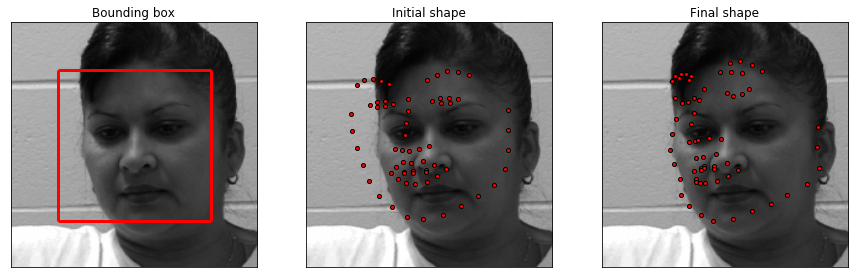

In [6]:
# Load detector
detect = load_dlib_frontal_face_detector()

# Load and convert to grayscale
image = mio.import_image(join(path_to_images, 'll042t1aaaff242.png'))
image = image.as_greyscale()

# Detect face
bboxes = detect(image)

# Crop the image for better visualization of the result
image = image.crop_to_landmarks_proportion(0.3, group='dlib_0')
bboxes[0] = image.landmarks['dlib_0'].lms

if len(bboxes) > 0:
    # Fit AAM
    result = fitter.fit_from_bb(image, bboxes[0], max_iters=[15, 5],
                                gt_shape=image.landmarks['PTS'].lms)
    print(result)

    # Visualize
    plt.subplot(131)
    image.view()
    bboxes[0].view(line_width=3, render_markers=False)
    plt.gca().set_title('Bounding box')

    plt.subplot(132)
    image.view()
    result.initial_shape.view(marker_size=4)
    plt.gca().set_title('Initial shape')

    plt.subplot(133)
    image.view()
    result.final_shape.view(marker_size=4, figure_size=(15, 13))
    plt.gca().set_title('Final shape')

### Feature Extraction

In [7]:
result.final_shape

PointCloud: n_points: 66, n_dims: 2

In [8]:
print training_images[0].landmarks.get('PTS')

PointCloud: n_points: 66, n_dims: 2


In [9]:
# extract shapes from images
shapes_an = [i.landmarks.get('PTS') for i in training_images]

# build reference frame
reference_frame_an = build_reference_frame(result.final_shape)

# Apply piece-wise affine warp on source images
warped_images_an = warp_images(training_images, shapes_an, reference_frame_an, PiecewiseAffine)

/Users/206479300/anaconda2/envs/conda_env/lib/python2.7/site-packages/menpofit/builder.py:338: MenpoFitModelBuilderWarning: The reference shape passed is not a TriMesh or subclass and therefore the reference frame (mask) will be calculated via a Delaunay triangulation. This may cause small triangles and thus suboptimal warps.
  MenpoFitModelBuilderWarning)
/Users/206479300/anaconda2/envs/conda_env/lib/python2.7/site-packages/menpo/image/boolean.py:711: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  copy.pixels[slices].flat = point_in_pointcloud(pointcloud, indices)


In [10]:
warped_images_an[0]

128W x 137H 2D MaskedImage with 1 channels. Attached mask 69.0% true

In [11]:
# extract shapes from images
shapes_a0 = [i.landmarks.get('PTS') for i in training_images]

# build reference frame
reference_frame_a0 = build_reference_frame(result.gt_shape)

# Apply piece-wise affine warp on source images
warped_images_a0 = warp_images(training_images, shapes_a0, reference_frame_a0, PiecewiseAffine)

In [12]:
warped_images_a0[0]

122W x 116H 2D MaskedImage with 1 channels. Attached mask 70.4% true

In [13]:
s_pts = result.final_shape.points
s_app = warped_images_an
c_app = warped_images_a0

### Prep data for model training + evaluation (Using S-APP Features)

#### Transform PSPI labels into 0/1 (pain vs no pain) and attach labels to images

In [14]:
final_training_images = s_app
final_training_labels = [int(label > 0.0) for label in training_labels]

In [15]:
print final_training_labels[:10]
print 'Number of labels showing pain: {}'.format(sum(final_training_labels))
print 'Number of labels showing no pain: {}'.format(len(final_training_labels) - sum(final_training_labels))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Number of labels showing pain: 108
Number of labels showing no pain: 575


#### Train/Test Data Split

In [16]:
vectorized_training_images = [sample.as_vector().tolist() for sample in final_training_images]
np.unique(list(map(len, vectorized_training_images)))

array([12097])

In [17]:
# Add labels to samples for clustering
samples = []
for image_idx, training_image in enumerate(vectorized_training_images):
    sample = training_image + [final_training_labels[image_idx]]
    samples.append(sample)

In [18]:
# Future enhancement: use k-fold cross-validation instead of one static split
training_percentage = 0.9
k = int(len(samples) * training_percentage)

training_indices = random.sample(xrange(len(samples)), k)
test_indices = list(set(range(len(samples))) - set(training_indices))

training_samples = [samples[index] for index in training_indices]
test_samples = [samples[index] for index in test_indices]

In [19]:
print(len(training_samples))
print(len(test_samples))

614
69


#### Cluster Samples (Video Frames) to reduce dataset for SVM

In [20]:
training_samples[-1][-1]

1

In [21]:
kmeans = KMeans(n_clusters=200, random_state=0).fit(training_samples)

### Model Training

#### Pull training samples from clusters

In [22]:
kmeans.labels_

array([ 22,  51, 113, 153, 121,  82, 102,  86,  28,  19, 166, 191, 170,
        82,  82,  76,  44,  20,  58, 156,  16,   4,  61, 132, 170,  54,
       159,  28,  50,  92, 161, 152, 179,  79, 109,  81,  78, 147,  90,
       117, 166,   6,  77,   8,  63,   9,  11,  19,  13, 128,  93,  11,
        14, 129,  77,  63,  82, 150,  77,  19,  72, 173,  78,  82, 183,
        15,  80, 147, 148, 166,  74, 133, 109,  74,  58,  10, 155,  68,
        15, 140,  26,  55,  22,   8, 183,  66,   8,  54,  50,  44, 126,
       150, 139, 153,  76,  54,  73,  38,  56,  69, 199,  29, 145, 105,
       103, 125,  13, 129,  48,  30, 124, 118, 134, 110,  43, 170, 115,
        95, 195,  44,   8, 114, 109, 165, 112, 137,  81, 150,  19,  86,
        53, 153,  15, 118,  89,   4, 166, 194,  15,  18, 129,  51, 146,
       164, 198,  46, 159,  18, 125, 177,  72, 126, 110, 164,  92,  94,
        66,  65,  30,  44,  14, 157,  14,  25,  99, 103,   2, 126,  98,
       120, 166,   7,   6, 132,  58,  37, 168, 182,  77, 171,  1

In [23]:
cluster_ids = set(range(200))
final_training_samples = []

for training_sample_idx, cluster_id in enumerate(kmeans.labels_.tolist()):
    if cluster_id in cluster_ids:
        final_training_samples.append(training_samples[training_sample_idx])
        cluster_ids.remove(cluster_id)

In [24]:
print len(final_training_samples)
print final_training_samples[0][-1]
print len(final_training_samples[0])

200
0
12098


#### Separate images from labels again

In [25]:
svm_training_labels = [sample[-1] for sample in final_training_samples]
svm_training_samples = [sample[:-1] for sample in final_training_samples]

svm_test_labels = [sample[-1] for sample in test_samples]
svm_test_samples = [sample[:-1] for sample in test_samples]

#### SVM Training

In [26]:
clf = svm.SVR(gamma='scale')
clf.fit(svm_training_samples, svm_training_labels)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

### Model Evaluation

In [30]:
raw_predictions = clf.predict(svm_test_samples).tolist()
predictions = [int(raw_prediction > 0.5) for raw_prediction in raw_predictions]

accuracy = float(sum([predictions[i] == svm_test_labels[i] for i in range(len(svm_test_labels))])) / float(len(predictions))

print 'Model accuracy: {}\n'.format(accuracy)

Model accuracy: 0.826086956522



In [34]:
sum(predictions)

7

In [45]:
sum(svm_test_labels)

17

[Text(0,0.5,'no pain'), Text(0,1.5,'pain')]

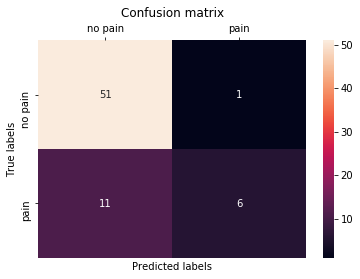

In [43]:
cm = confusion_matrix(svm_test_labels, predictions)

# plot heatmap of confusion matrix
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax)

# labels, title and ticks
plt.title('Confusion matrix', y=1.08)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.xaxis.tick_top()
ax.xaxis.set_ticklabels(['no pain', 'pain'])
ax.yaxis.set_ticklabels(['no pain', 'pain'])